# IWAL + Stopping Criteria

This code is adapted from my HW2, Exercise 2 implementation of IWAL. 

In [3]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#read the data: note there is no header
df = pd.read_csv('/Users/jonathanzhu/Documents/data/vc_mutant_data.csv', header=None)

#rename columns: all are x0, x1, x2, etc. except the last one, which is "Class"
df.columns = ['x' + str(i) for i in range(0, 512)] + ['Class']
df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x503,x504,x505,x506,x507,x508,x509,x510,x511,Class
0,0.052671,-0.170843,0.127665,-0.157065,0.149449,-0.405221,-0.015877,1.019597,0.306551,0.057538,...,1.002674,0.837392,1.133352,-0.255242,0.919627,-0.167685,1.559194,0.124128,0.642259,flaA
1,0.010678,-0.170641,0.137485,-0.158542,0.166123,-0.352311,0.006440,1.031316,0.309140,-0.023432,...,0.972432,0.887417,1.089113,-0.302200,0.849822,-0.190138,1.495022,0.091063,0.695978,flaA
2,0.031659,-0.180831,0.093920,-0.172080,0.157711,-0.415934,-0.031329,1.123129,0.252306,0.008820,...,1.016015,0.926723,1.136414,-0.335968,0.847125,-0.204482,1.524836,0.071172,0.737653,flaA
3,0.075516,-0.196257,0.198255,-0.160592,0.085160,-0.361760,-0.018122,0.951612,0.351116,0.023851,...,0.971781,0.756529,1.104958,-0.238443,0.922150,-0.206724,1.502505,0.139053,0.605317,flaA
4,0.040185,-0.159659,0.070033,-0.151958,0.170973,-0.406942,-0.017921,1.155567,0.306783,-0.005056,...,0.957689,0.918439,1.098478,-0.306227,0.833798,-0.207886,1.530353,0.123505,0.696751,flaA


In [ ]:
#items in the "Class" column are currently strings - convert to integers
items = df['Class'].unique()
corresponding_dict = {items[i]: i for i in range(len(items))}

df['Class'] = df['Class'].map(corresponding_dict)
df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x503,x504,x505,x506,x507,x508,x509,x510,x511,Class
0,0.052671,-0.170843,0.127665,-0.157065,0.149449,-0.405221,-0.015877,1.019597,0.306551,0.057538,...,1.002674,0.837392,1.133352,-0.255242,0.919627,-0.167685,1.559194,0.124128,0.642259,0
1,0.010678,-0.170641,0.137485,-0.158542,0.166123,-0.352311,0.006440,1.031316,0.309140,-0.023432,...,0.972432,0.887417,1.089113,-0.302200,0.849822,-0.190138,1.495022,0.091063,0.695978,0
2,0.031659,-0.180831,0.093920,-0.172080,0.157711,-0.415934,-0.031329,1.123129,0.252306,0.008820,...,1.016015,0.926723,1.136414,-0.335968,0.847125,-0.204482,1.524836,0.071172,0.737653,0
3,0.075516,-0.196257,0.198255,-0.160592,0.085160,-0.361760,-0.018122,0.951612,0.351116,0.023851,...,0.971781,0.756529,1.104958,-0.238443,0.922150,-0.206724,1.502505,0.139053,0.605317,0
4,0.040185,-0.159659,0.070033,-0.151958,0.170973,-0.406942,-0.017921,1.155567,0.306783,-0.005056,...,0.957689,0.918439,1.098478,-0.306227,0.833798,-0.207886,1.530353,0.123505,0.696751,0


In [8]:
import pickle
#save the classes to a pickle file for later use
with open('vc_classes.pkl', 'wb') as f:
    pickle.dump(corresponding_dict, f)

For this exercise, we will be implementing the IWAL algorithm specified by Beygelzimer et al. (2009) The pseudocode listed in the paper details the following steps:

Set $S_0 = \emptyset$
For $t$ from 1 until the data stream runs out:
1. Receive $x_t$
2. $p_t = $ rejection-threshold $(x_t, history \{x_i, y_i, p_i, Q_i: 1 \leq i \leq t\})$
3. Flip a coin with prob of 1 as $p_t$. If 1, request $Q_t$ with weight $p_{min}/p_t$
4. Update training to minimize weighted loss. 


In [9]:
from sklearn.tree import DecisionTreeClassifier
#random forest
from sklearn.ensemble import RandomForestClassifier

In [87]:
#subroutine for IWAL: bootstrapping to define the rejection-threshold subroutine
"""BootstrappingIWAL() takes in the following parameters:
- new_ex: a single new example
- x_hist: all previous examples
- y_hist: all previous labels
- model_hist: all previous models (default to None, in the case they are not made)
- b: length of the initial bootstrap sample
- k: number of bootstrap samples/predictors used in the voting
- t: current time step
- p_min: lower bound on rejection threshold
"""
def BootstrappingIWAL(new_ex, data_hist, models, b, k, t, p_min):
    #first check: t < b
    if t <= b:
        p_t = 1
    
    #second check: t = b
    if t == b:
        #train k predictors on the initial sample
        predictors = []

        for i in range(k):
            clf = DecisionTreeClassifier() #Decision Tree is for the bootstrapped predictors
            curr_sample = get_bootstrap_sample(data_hist)
            clf.fit(curr_sample.iloc[:, :-2], curr_sample.iloc[:, -2])
            predictors.append(clf)
    else:
        predictors = models
    
    #third check: t > b
    if t > b:
        #in this case, p_t is equal to p_min + (1 - p_min) 
        #times the maximum of the difference between losses of any two models in the ensemble, for any two predictions

        #to approach this: first, make predictions for each model
        preds = []
        for model in predictors:
            preds.append(model.predict(new_ex.iloc[:, :-1]))
        
        #the preds is a list of lists, where each list is the predictions of a model
        #convert this to a numpy array
        preds = np.array(preds)
        #take negative log for CE-loss
        preds = -np.log(preds)

        #for each column, get the maximum and minimum
        maxes = np.max(preds, axis = 0)
        mins = np.min(preds, axis = 0)
        diffs = maxes - mins

        #get the maximum difference
        max_diff = np.max(diffs)

        #calculate p_t
        p_t = p_min + (1 - p_min) * max_diff

    if p_t > 1:
        p_t = 1
    if p_t < 0:
        p_t = 0

    return p_t, predictors

#helper function: get a bootstrapped sample from a dataframe
def get_bootstrap_sample(data):
    bootstrap = data.sample(n = len(data), replace = True)
    return bootstrap

#now time to define the full IWAL algorithm
"""IWAL() takes in the following parameters:
- x: all examples
- y: all labels
- b: length of the initial bootstrap sample
- k: number of bootstrap samples/predictors used in the voting
- p_min: lower bound on rejection threshold
"""
def IWAL(data, b, k, p_min):
    #initialize empty lists for the histories
    data_hist = pd.DataFrame(columns = data.columns)
    models = []
    
    #furthermore: lists for probabilities and 0/1 for each example being chosen
    p_hist = []
    Q_hist = [] #0/1

    #initialize a list for weights
    c = []

    #initialize a list for loss and accuracy
    losses = []
    accs = []

    #finally, initialize the dataframe to hold the selected examples
    selected = pd.DataFrame(columns = data.columns)
    #shuffle data
    data = data.sample(frac = 1).reset_index(drop = True)

    #iterate through all examples
    for t in range(len(data)):
        print("Iteration ", t)

        #receive x_t
        x_t = data.iloc[t]
        new_point = pd.DataFrame(x_t).T
        
        #get the probability of x_t being chosen, also the models
        p_t, models = BootstrappingIWAL(new_point, data_hist, models, b, k, t, p_min)
        #check if x_t is chosen by flipping a coin with probability p_t
        Q_t = np.random.binomial(1, p_t)
        Q_hist.append(Q_t)
        if Q_t == 1:
            #add x_t to the selected examples if it is chosen
            selected = pd.concat([selected, new_point])

            #add to histories
            data_hist = pd.concat([data_hist, new_point])
            p_hist.append(p_t)
            
            c.append(p_min / p_t)
        #learn an importance-weighted classifier on the selected examples
        h_t, loss, acc = LearnWeightedClassifier(data_hist, c)
        print(loss)
        #print("Iteration ", t, " loss: ", loss, " accuracy: ", acc)
        losses.append(loss)
        accs.append(acc)

    return selected, h_t, losses, accs

#helper function: make v folds for cross-validation
def create_folds(data, v = 5):
    #initialize the folds
    folds = []
    
    #get the number of examples
    n = len(data)
    #get the size of each fold
    fold_size = n // v

    #shuffle the data
    data = data.sample(frac = 1).reset_index(drop = True)

    #iterate through the folds
    for i in range(v):
        #get the start and end indices for the fold
        start = i * fold_size
        end = (i + 1) * fold_size

        #get the fold
        fold = data.iloc[start:end]
        folds.append(fold)

    return folds

#helper function: given labelled data and a list of weights, learn a classifier that minimizes weighted 0-1 loss
def LearnWeightedClassifier(data, w): 
    #add weights to the data
    #weights are the last column
    data['weights'] = w

    #create folds for cross-validation
    folds = create_folds(data)
    accs = []
    losses = []

    for i in range(len(folds)):
        #get the training and validation sets
        val = folds[i]
        #training is all other folds combined
        train = pd.concat(folds[:i] + folds[i+1:])
        classes = train['Class'].unique()

        #check: the validation set must have >1 example
        if len(val) <= 1:
            return None, np.nan, np.nan

        #initialize the classifier
        clf = RandomForestClassifier(n_estimators = 20, max_depth = 7, random_state = 42)
        #train the weighted classifier
        clf.fit(train.iloc[:, :-2], train['Class'], sample_weight = train['weights'])
        
        #predict on the validation set
        preds = clf.predict(val.iloc[:, :-2])
        probs = clf.predict_proba(val.iloc[:, :-2])
        #calculate the weighted loss
        loss = 0
        n = len(preds)
        for j in range(len(preds)):
            if preds[j] == val['Class'].iloc[j]:
                pred_class = int(preds[j])
                #locate the index of the class
                class_index = np.where(classes == pred_class)[0][0]
                loss += (val['weights'].iloc[j] * -np.log(probs[j][class_index] + 1e-10)) / n

        #sometimes loss will be in an array, like [0.5]
        #in this case, we just want the number
        if type(loss) == np.ndarray:
            loss = loss[0]

        loss /= len(preds)
        #print(loss)
        losses.append(loss)

        #calculate the accuracy
        acc = clf.score(val.iloc[:, :-2], val['Class'])
        accs.append(acc)
    
    #print(np.array(losses))
    #get the average loss and accuracy
    loss_full = np.mean(np.array(losses))
    acc = np.mean(accs)

    return clf, loss_full, acc



In [88]:
#simulate active learning by IWAL 10 times
#with parameters b = 20% of the data, k = 10, p_min = 0.1
accs_iwal = []
losses_iwal = []
selected_all = []
b = 20
k = 10
p_min = 0.1

#just to test - smaller sample
df_sample = df.sample(frac=0.2, random_state=42)

for i in range(10):
    selected, h_t, losses, accs = IWAL(df_sample, b, k, p_min)
    accs_iwal.append(accs)
    losses_iwal.append(losses)
    selected_all.append(selected)
    
    print("Simulation", i, "done")

Iteration  0
nan
Iteration  1
nan
Iteration  2
nan
Iteration  3
nan
Iteration  4
nan
Iteration  5
nan
Iteration  6
nan
Iteration  7
nan
Iteration  8
nan
Iteration  9
0.0
Iteration  10
0.0
Iteration  11
0.02302585091994046
Iteration  12
0.04845197166280134
Iteration  13
0.2616542423818701
Iteration  14
0.07381560122058155
Iteration  15
0.10387744231164635
Iteration  16
0.11246240417795672
Iteration  17
0.1417316342533852
Iteration  18
0.1258851924143933
Iteration  19
0.07843145205926183
Iteration  20
0.10346910038299492
Iteration  21
0.142618976087923
Iteration  22
0.0776002316783298
Iteration  23
0.012728588519761974
Iteration  24
0.09580423083376313
Iteration  25
0.06761459968746841
Iteration  26
0.11355113551620474
Iteration  27
0.12923820867766897
Iteration  28
0.11413653087309579
Iteration  29
0.14182584125145348
Iteration  30
0.0951226799164148
Iteration  31
0.13065714579351062
Iteration  32
0.03846909467348327
Iteration  33
0.10446104621903066
Iteration  34
0.12208914503387258
It

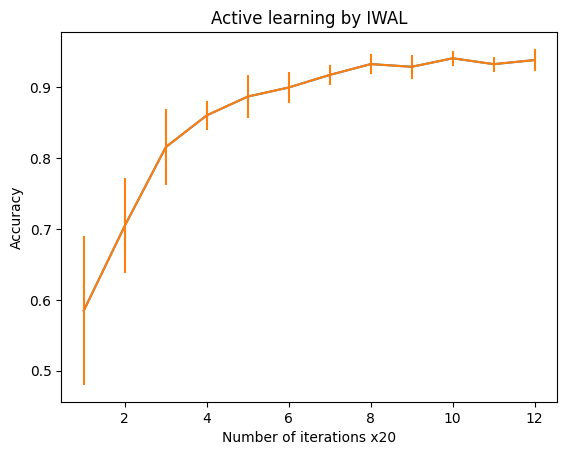

In [89]:
#plot the results
accs_iwal = np.array(accs_iwal)
mean_accs_iwal = accs_iwal.mean(axis=0)
std_accs_iwal = accs_iwal.std(axis=0)

#select every 20th point for better visualization
mean_accs_iwal = mean_accs_iwal[::20]
std_accs_iwal = std_accs_iwal[::20]

plt.plot(mean_accs_iwal)
plt.errorbar(range(len(mean_accs_iwal)), mean_accs_iwal, yerr=std_accs_iwal)
plt.xlabel("Number of iterations x20")
plt.ylabel("Accuracy")
plt.title("Active learning by IWAL")
plt.show()

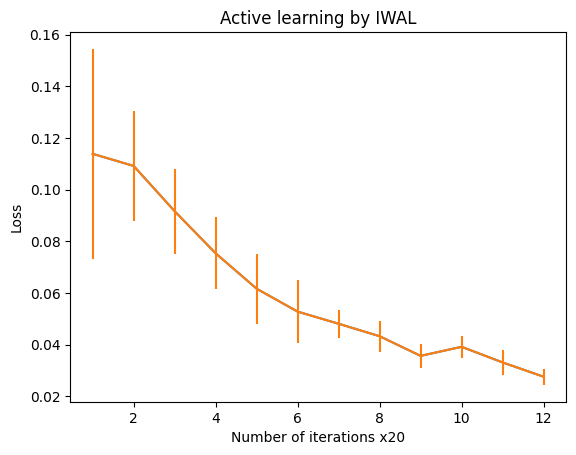

In [90]:
#same as above, but with loss
losses_iwal = np.array(losses_iwal)
mean_losses_iwal = losses_iwal.mean(axis=0)
std_losses_iwal = losses_iwal.std(axis=0)

#select every 20th point for better visualization
mean_losses_iwal = mean_losses_iwal[::20]
std_losses_iwal = std_losses_iwal[::20]

plt.plot(mean_losses_iwal)
plt.errorbar(range(len(mean_losses_iwal)), mean_losses_iwal, yerr=std_losses_iwal)
plt.xlabel("Number of iterations x20")
plt.ylabel("Loss")
plt.title("Active learning by IWAL")
plt.show()

In [17]:
import pickle
#load metrics from ex1.pkl
with open('ex1.pkl', 'rb') as f:
    mean_accs, std_accs, mean_accs_density, std_accs_density, mean_accs_passive, std_accs_passive = pickle.load(f)

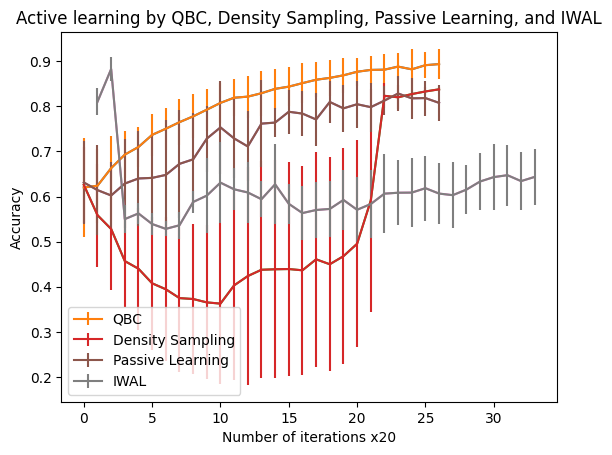

In [18]:
#full plot with everything on it
plt.plot(mean_accs)
plt.errorbar(range(len(mean_accs)), mean_accs, yerr=std_accs, label="QBC")
plt.plot(mean_accs_density)
plt.errorbar(range(len(mean_accs_density)), mean_accs_density, yerr=std_accs_density, label="Density Sampling")
plt.plot(mean_accs_passive)
plt.errorbar(range(len(mean_accs_passive)), mean_accs_passive, yerr=std_accs_passive, label="Passive Learning")
plt.plot(mean_accs_iwal)
plt.errorbar(range(len(mean_accs_iwal)), mean_accs_iwal, yerr=std_accs_iwal, label="IWAL")
plt.xlabel("Number of iterations x20")
plt.ylabel("Accuracy")
plt.title("Active learning by QBC, Density Sampling, Passive Learning, and IWAL")
plt.legend()
plt.show()

In [19]:
import dill
dill.dump_session('ex2.db')

#load all of these and IWAL results into a new pickle file
with open('ex2.pkl', 'wb') as f:
    pickle.dump([mean_accs, std_accs, mean_accs_density, std_accs_density, mean_accs_passive, std_accs_passive, mean_accs_iwal, std_accs_iwal], f)